<a href="https://colab.research.google.com/github/ribesstefano/PROTAC-Degradation-Predictor/blob/main/notebooks/protac_degradation_predictor_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROTAC-Degradation-Predictor: Tutorial

This notebook includes a short tutorial and a collection of code snippets for predicting protein degradation by PROTACs.

The underlined deep learning models have been trained and evaluated as reported in [_"Modeling PROTAC Degradation Activity with Machine Learning"_](https://arxiv.org/abs/2406.02637).

## Clone Repository and Install Package

In [22]:
!git clone https://github.com/ribesstefano/PROTAC-Degradation-Predictor.git
!pip install ./PROTAC-Degradation-Predictor  -qqq

fatal: destination path 'PROTAC-Degradation-Predictor' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


## Setup

Let's import the required packages:

In [36]:
import protac_degradation_predictor as pdp
import torch
from rdkit import Chem

## Loading Curated Dataset

The curated dataset can be loaded via the following code:

In [29]:
protac_df = pdp.load_curated_dataset()
display(protac_df.head())

,Compound ID,Uniprot,Smiles,E3 Ligase,InChI,InChI Key,Molecular Weight,Heavy Atom Count,Ring Count,Rotatable Bond Count,...,Name,Assay (DC50/Dmax),Exact Mass,XLogP3,Target (Parsed),POI Sequence,E3 Ligase Uniprot,E3 Ligase Sequence,Cell Line Identifier,Active - OR
0,1,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C73H88ClF3N10O10S4/c1-47(49-13-15-51(...,SXPDUCVNMGMWBJ-FMZBIETASA-N,1486.282,101,10,24,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
1,2,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C74H90ClF3N10O10S4/c1-48(50-13-15-52(...,HQKUMELJMUNTTF-NMKDNUEVSA-N,1500.309,102,10,25,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
2,3,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C75H92ClF3N10O10S4/c1-49(51-16-18-53(...,ATQCEJKUPSBDMA-QARNUTPLSA-N,1514.336,103,10,26,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
3,4,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C76H94ClF3N10O10S4/c1-50(52-17-19-54(...,FNKQAGMHNFFSEI-DTTPTBRMSA-N,1528.363,104,10,27,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,NaN
4,5,Q07817,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,InChI=1S/C77H96ClF3N10O10S4/c1-51(53-18-20-55(...,PXVFFBGSTYQHRO-REQIQPEASA-N,1542.390,105,10,28,...,NaN,NaN,NaN,NaN,NaN,MSQSNRELVVDFLSYKLSQKGYSWSQFSDVEENRTEAPEGTESEME...,P40337,MPRRAENWDEAEVGAEEAGVEEYGPEEDGGEESGAEESGPEESGPE...,MOLT-4,True


The dataset includes entries for which either (or both) $pDC_{50}$ or $D_{max}$ information about PROTAC are available. We can isolate data for which we know both information:

In [31]:
pDC50_threshold = 6.0
Dmax_threshold = 0.6

protac_df['E3 Ligase'] = protac_df['E3 Ligase'].str.replace('Iap', 'IAP')
protac_df['Active'] = protac_df.apply(
    lambda x: pdp.is_active(x['DC50 (nM)'], x['Dmax (%)'], pDC50_threshold=pDC50_threshold, Dmax_threshold=Dmax_threshold), axis=1
)

protac_df = protac_df[~protac_df['Active'].isna()]

relevant_cols = ['Uniprot', 'Cell Line Identifier', 'Smiles', 'E3 Ligase', 'DC50 (nM)', 'Dmax (%)', 'Active']
display(protac_df[relevant_cols])

,Uniprot,Cell Line Identifier,Smiles,E3 Ligase,DC50 (nM),Dmax (%),Active
4,Q07817,MOLT-4,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,53.0,100.0,True
7,Q07817,MOLT-4,Cc1ncsc1-c1ccc([C@H](C)NC(=O)[C@@H]2C[C@@H](O)...,VHL,93.0,90.0,True
60,P00533,H1975/WR,C=CC(=O)Nc1cccc(-n2c(=O)cc(C)c3cnc(Nc4ccc(N5CC...,VHL,25.3,90.0,True
69,P00533,H1975/WR,C=CC(=O)Nc1cccc(-n2c(=O)cc(C)c3cnc(Nc4ccc(N5CC...,VHL,5.9,100.0,True
72,Q9NWZ3,PH1-PBMCs-hiPSC4F1,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...,VHL,3000.0,50.0,False
...,...,...,...,...,...,...,...
2121,O60885,HEK293T,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCO...,FEM1B,820.0,81.0,True
2122,O60885,HEK293T,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCC...,FEM1B,250.0,94.0,True
2125,O60885,HEK293T,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCO...,FEM1B,1100.0,85.0,False
2126,O60885,HEK293T,Cc1sc2c(c1C)C(c1ccc(Cl)cc1)=N[C@@H](CC(=O)NCCO...,FEM1B,3600.0,60.0,False


## Predicting Protein Degradation

First, let's get the device to run the models onto.

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device to offload computations to: {device.upper()}')

Device to offload computations to: CPU


We can now have a simple example involving the following PROTAC molecule:

In [34]:
example = protac_df.sample(1, random_state=42)
display(example[relevant_cols])

,Uniprot,Cell Line Identifier,Smiles,E3 Ligase,DC50 (nM),Dmax (%),Active
1871,Q92769,HCT116-53BPI(+/-),Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O...,VHL,NaN,23.0,False


PROTAC SMILES: Cc1ncsc1-c1ccc(CNC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)COCCCCCCCCCOCC(=O)Nc2ccc(C(=O)Nc3ccc(F)cc3N)cc2)C(C)(C)C)cc1


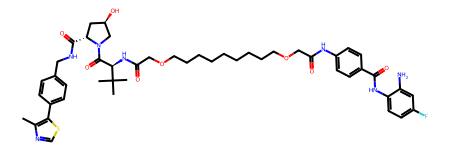

In [43]:
protac_smiles = example['Smiles'].iloc[0]
print(f'PROTAC SMILES: {protac_smiles}')
display(Chem.MolFromSmiles(protac_smiles))

The "biological context" will be:
- a VHL E3 ligase
- protein P04637 (Uniprot) as POI
- in HeLa cell line

In [46]:
e3_ligase = example['E3 Ligase'].iloc[0]
target_uniprot = example['Uniprot'].iloc[0]
cell_line = example['Cell Line Identifier'].iloc[0]

print(f'E3 Ligase: {e3_ligase}')
print(f'POI:       {target_uniprot}')
print(f'Cell line: {cell_line}')

E3 Ligase: VHL
POI:       Q92769
Cell line: HCT116-53BPI(+/-)


Given the PROTAC SMILES and its biological context, we can predict its activity.

Please note that a PROTAC has been defined active when both the following conditions are true:
- $pDC_{50} \ge 6.0$
- $D_{max} \ge 60\%$

In [47]:
true_activity = example['Active'].iloc[0]

active_protac = pdp.is_protac_active(
    protac_smiles,
    e3_ligase,
    target_uniprot,
    cell_line,
    device=device,
    proba_threshold=0.5, # Default value
)
print(f'The given PROTAC is predicted {"active" if active_protac else "inactive"} (True activity: {"active" if true_activity else "inactive"}).')

The given PROTAC is predicted inactive (True activity: inactive).


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


If one is interested in the _probability_ of the PROTAC being active, we can run the function `get_protac_active_proba`.

The function returns the predictions of three models, along side with their mean and majority vote prediction (both as Numpy arrays):

In [55]:
prediction = pdp.get_protac_active_proba(
    protac_smiles,
    e3_ligase,
    target_uniprot,
    cell_line,
    device=device,
)

active_protac_prob = prediction["mean"][0]

if not active_protac:
    active_protac_prob = 1 - active_protac_prob

print(f'The given PROTAC is {"active" if active_protac else "inactive"} with probability: {active_protac_prob:.3f}')

The given PROTAC is inactive with probability: 0.818


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


One can also inspect the single predictions by each model, like so:

In [57]:
for i, pred in enumerate(prediction['preds']):
    print(f'Model n.{i} prediction: {pred:.4f}')

Model n.0 prediction: 0.1702


### Batch Processing

To speed up computation, multiple PROTACs can be processed in "one shot" by simply passing them as lists, as follows:

In [58]:
batch_size = 16

examples = protac_df.sample(batch_size, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


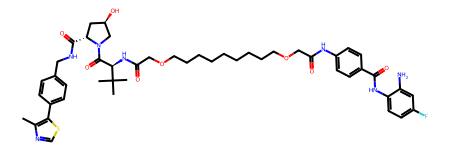

Inactive
--------------------------------------------------------------------------------


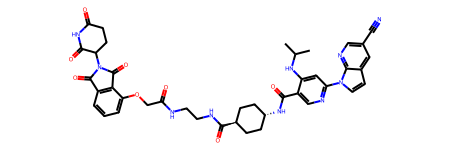

Inactive
--------------------------------------------------------------------------------


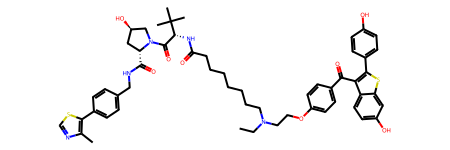

Inactive
--------------------------------------------------------------------------------


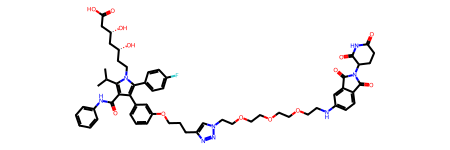

Inactive
--------------------------------------------------------------------------------


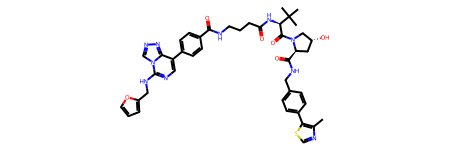

Active
--------------------------------------------------------------------------------


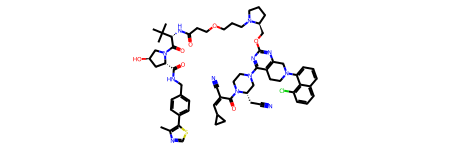

Active
--------------------------------------------------------------------------------


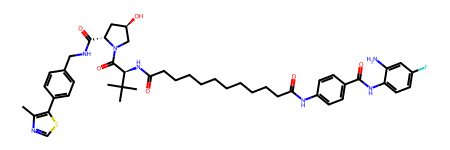

Inactive
--------------------------------------------------------------------------------


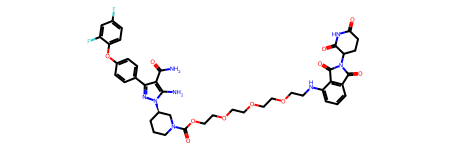

Inactive
--------------------------------------------------------------------------------


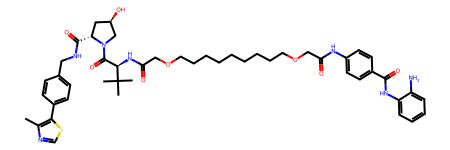

Inactive
--------------------------------------------------------------------------------


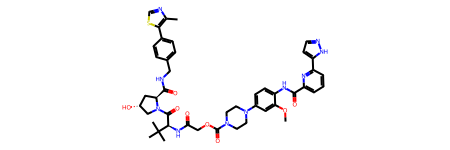

Active
--------------------------------------------------------------------------------


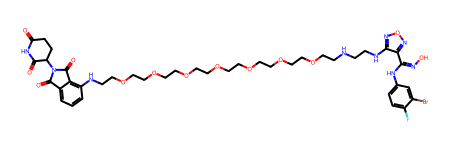

Inactive
--------------------------------------------------------------------------------


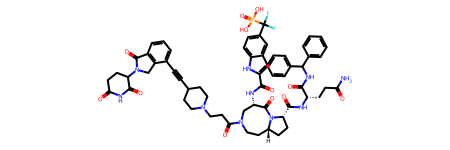

Inactive
--------------------------------------------------------------------------------


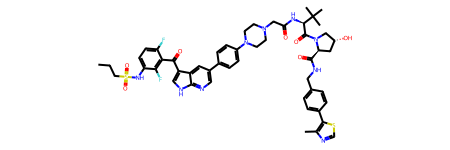

Active
--------------------------------------------------------------------------------


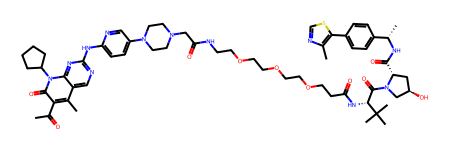

Active
--------------------------------------------------------------------------------


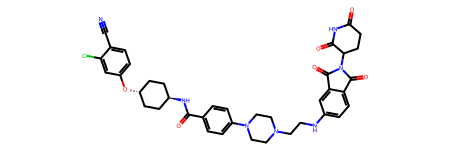

Inactive
--------------------------------------------------------------------------------


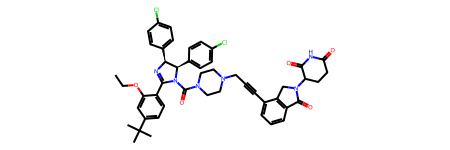

Active
--------------------------------------------------------------------------------


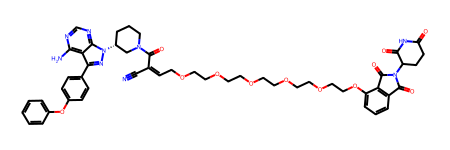

Active
--------------------------------------------------------------------------------


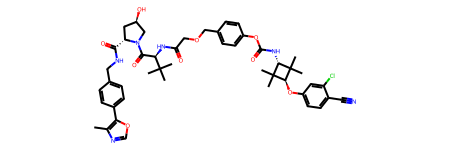

Active
--------------------------------------------------------------------------------


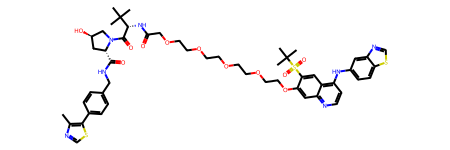

Active
--------------------------------------------------------------------------------


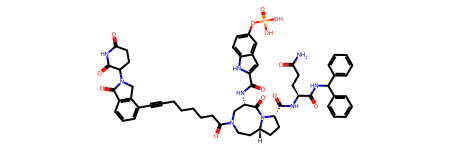

Inactive
--------------------------------------------------------------------------------


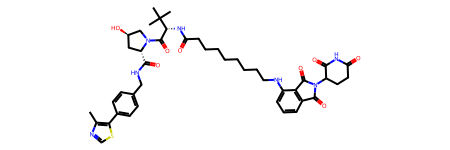

Active
--------------------------------------------------------------------------------


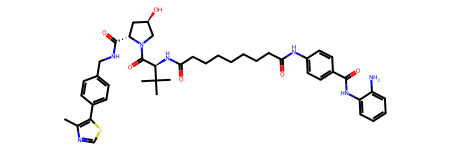

Inactive
--------------------------------------------------------------------------------


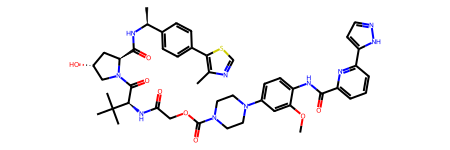

Active
--------------------------------------------------------------------------------


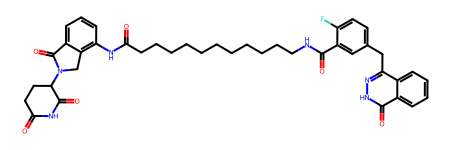

Inactive
--------------------------------------------------------------------------------


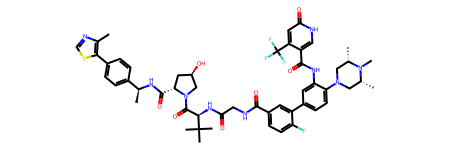

Active
--------------------------------------------------------------------------------


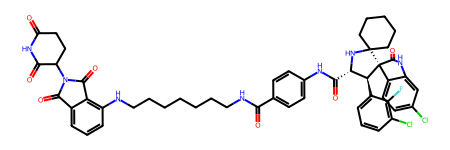

Inactive
--------------------------------------------------------------------------------


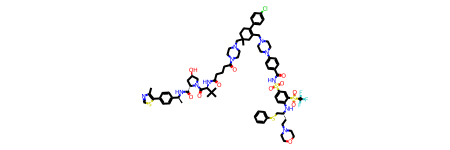

Active
--------------------------------------------------------------------------------


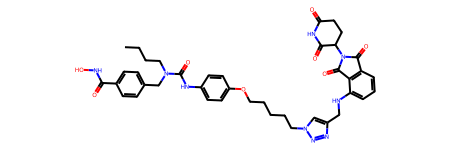

Active
--------------------------------------------------------------------------------


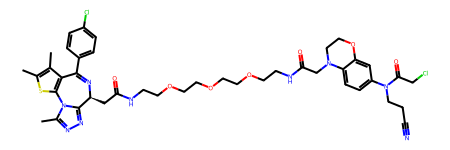

Inactive
--------------------------------------------------------------------------------


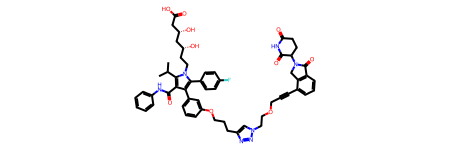

Inactive
--------------------------------------------------------------------------------


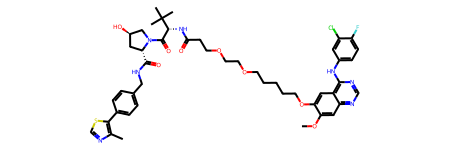

Inactive
--------------------------------------------------------------------------------


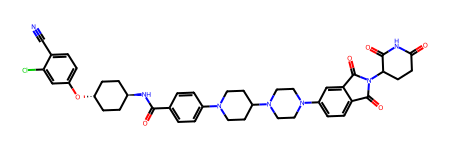

Active
--------------------------------------------------------------------------------


In [59]:
predictions = pdp.get_protac_active_proba(
    protac_smiles=examples['Smiles'].tolist(),
    e3_ligase=examples['E3 Ligase'].tolist(),
    target_uniprot=examples['Uniprot'].tolist(),
    cell_line=examples['Cell Line Identifier'].tolist(),
    device=device,
)['majority_vote']

for smiles, active in zip(examples['Smiles'].tolist(), predictions):
    display(Chem.MolFromSmiles(smiles))
    print(f'{"Active" if active else "Inactive"}')
    print('-' * 80)

## Getting Available Data Options

Currently, the package relies on precomputed embeddings for POI, E3 ligase, and cell line.
Therefore, inputs to the prediction function must be among the available data.

Note that this is not true for the PROTAC SMILES, which can be anything "reasonable" candidate.

To get the list of available data to choose from, one can use the following functions:

In [64]:
print(f'Number of available E3 ligases:  {len(pdp.avail_e3_ligases()):,}')
print(f'Number of available Uniprot IDs: {len(pdp.avail_uniprots()):,}')
print(f'Number of available cell lines:  {len(pdp.avail_cell_lines()):,}')
print(f'')
print(f'Available E3 ligases:                         {pdp.avail_e3_ligases()}')
print(f'Available Uniprot IDs (showing the first 32): {pdp.avail_uniprots()[:32]}')
print(f'Available cell lines (showing the first 32):  {pdp.avail_cell_lines()[:32]}')

Number of available E3 ligases:  16
Number of available Uniprot IDs: 20,594
Number of available cell lines:  1,138

Available E3 ligases:                         ['VHL', 'CRBN', 'DCAF11', 'DCAF15', 'DCAF16', 'MDM2', 'Mdm2', 'XIAP', 'cIAP1', 'IAP', 'Iap', 'AhR', 'RNF4', 'RNF114', 'FEM1B', 'Ubr1']
Available Uniprot IDs (showing the first 32): ['A0A024R1R8', 'A0A024RBG1', 'A0A024RCN7', 'A0A075B6H5', 'A0A075B6H7', 'A0A075B6H8', 'A0A075B6H9', 'A0A075B6I0', 'A0A075B6I1', 'A0A075B6I3', 'A0A075B6I4', 'A0A075B6I6', 'A0A075B6I7', 'A0A075B6I9', 'A0A075B6J1', 'A0A075B6J2', 'A0A075B6J6', 'A0A075B6J9', 'A0A075B6K0', 'A0A075B6K2', 'A0A075B6K4', 'A0A075B6K5', 'A0A075B6K6', 'A0A075B6L2', 'A0A075B6L6', 'A0A075B6N1', 'A0A075B6N2', 'A0A075B6N3', 'A0A075B6N4', 'A0A075B6P5', 'A0A075B6Q5', 'A0A075B6R0']
Available cell lines (showing the first 32):  ['GM15119', 'GM17453', '84 BLCL', 'HQ00019', 'RFGd9WE', 'LG-11', 'TO 167.T', 'BayGenomics ES cell line RRA095', 'TPMab-3', 'DA02391', 'CW40101', 'CHLA-99', 'BayGe